# Electric consumption (KWH) by household

**Learning Objectives:**
  * Data model for KWH

2009 RECS (Residential Energy Consumption Survey) data

The set of 12,083 households selected at random using a complex multistage, area-probability sample design. This sample represents 113.6 million U.S. households. Each household is described by 931 features including type of household, number of appliances, energy consumption.

Data: https://www.eia.gov/consumption/residential/data/2009/index.php?view=microdata

Data file was downloaded as CSV. "Variable and response codebook" was converted from XLSX into CSV

Data Details: https://www.eia.gov/consumption/residential/methodology/2009/pdf/using-microdata-022613.pdf


Attention to detail:

Caveat* The "NWEIGHT" provides final sample weight as representation for the U.S. households.

Caveat** The "SCALEEL" contains manipulated numbers for the electricity consumption billing data


## Initialization
Load the libraries.

In [2]:
# Ensure the right version of Tensorflow is installed.
!pip freeze | grep tensorflow==2.3

In [3]:
import math
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style='whitegrid',font_scale=1.2)
# print(tf.__version__)
# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)
# pd.options.display.max_rows = 10
# pd.options.display.float_format = '{:.1f}'.format

Load the data set. The csv has been uploaded into Bigquery as public data.

In [4]:
 pip install google-cloud-bigquery==1.23.0

Note: you may need to restart the kernel to use updated packages.


In [5]:
#edit pandas settings for seeing all 940 columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
#spend some time learning the data
#Assumptions for brevity
    #KWH will be the original reading (SCALEEL=0 not scaled) 
    #household had more than zero bedrooms (removing 0 and Not Applicable)

In [6]:
#csv data was uploaded as publicly shared data file as well as queryable BigQuery table:
sql ="""
SELECT
  *
FROM
energypager1.recs2009.recs2009_p
"""
from google.cloud import bigquery
df = bigquery.Client().query(sql).to_dataframe()

## Exploratory Data Analysis

Print out quick summary of the statistics: include  mean, standard deviation, max, min, and quantiles.

In [7]:
df.describe()

DOEID       REGIONC      DIVISION  REPORTABLE_DOMAIN  \
count  12083.000000  12083.000000  12083.000000       12083.000000   
mean    6042.000000      2.628321      5.373086          14.783663   
std     3488.205986      1.042142      2.859366           8.195824   
min        1.000000      1.000000      1.000000           1.000000   
25%     3021.500000      2.000000      3.000000           8.000000   
50%     6042.000000      3.000000      5.000000          15.000000   
75%     9062.500000      3.000000      7.000000          21.000000   
max    12083.000000      4.000000     10.000000          27.000000   

            TYPEHUQ       NWEIGHT         HDD65         CDD65       HDD30YR  \
count  12083.000000  12083.000000  12083.000000  12083.000000  12083.000000   
mean       2.659604   9402.981870   4141.375238   1415.406108   4135.146983   
std        1.192627   5192.101419   2317.759375   1134.659475   2260.543686   
min        1.000000    476.100000      0.000000      0.000000      0.000000   
25%        2.000000   6297.040000   2197.500000    561.000000   2224.000000   
50%        2.000000   7970.630000   4483.000000   1045.000000   4502.000000   
75%        3.000000  11330.030000   5913.000000   1897.000000   5854.000000   
max        5.000000  95779.140000  12525.000000   5480.000000  13346.000000   

            CDD30YR  Climate_Region_Pub      AIA_Zone      KOWNRENT  \
count  12083.000000        12083.000000  12083.000000  12083.000000   
mean    1443.503104            2.601010      3.265000      1.338078   
std     1021.748722            1.349571      1.278652      0.497299   
min        0.000000            1.000000      1.000000      1.000000   
25%      712.000000            1.000000      2.000000      1.000000   
50%     1179.000000            3.000000      3.000000      1.000000   
75%     1842.500000            4.000000      4.000000      2.000000   
max     5357.000000            5.000000      5.000000      3.000000   

           CONDCOOP      YEARMADE  YEARMADERANGE  OCCUPYYRANGE    CONVERSION  \
count  12083.000000  12083.000000   12083.000000  12083.000000  12083.000000   
mean      -1.801457   1971.062402       4.027725      6.691964     -1.752793   
std        0.784550     24.817912       2.119578      1.535312      0.865886   
min       -2.000000   1920.000000       1.000000      1.000000     -2.000000   
25%       -2.000000   1955.000000       2.000000      6.000000     -2.000000   
50%       -2.000000   1975.000000       4.000000      7.000000     -2.000000   
75%       -2.000000   1991.000000       6.000000      8.000000     -2.000000   
max        2.000000   2009.000000       8.000000      8.000000      2.000000   

           ORIG1FAM      LOOKLIKE       NUMFLRS       NUMAPTS      WALLTYPE  \
count  12083.000000  12083.000000  12083.000000  12083.000000  12083.000000   
mean      -1.952164     -1.955640     -1.066705      4.486717      2.738889   
std        0.364856      0.386862      2.766326     29.662574      1.512821   
min       -2.000000     -2.000000     -2.000000     -2.000000      1.000000   
25%       -2.000000     -2.000000     -2.000000     -2.000000      2.000000   
50%       -2.000000     -2.000000     -2.000000     -2.000000      3.000000   
75%       -2.000000     -2.000000     -2.000000     -2.000000      3.000000   
max        1.000000      2.000000     35.000000    365.000000      9.000000   

           ROOFTYPE        STUDIO      NAPTFLRS       STORIES      TYPEHUQ4  \
count  12083.000000  12083.000000  12083.000000  12083.000000  12083.000000   
mean       3.676157     -1.510635     -1.269635     10.507738     -1.899694   
std        2.772088      0.890336      1.323690      8.779010      0.472066   
min       -2.000000     -2.000000     -2.000000     -2.000000     -2.000000   
25%        2.000000     -2.000000     -2.000000     10.000000     -2.000000   
50%        5.000000     -2.000000     -2.000000     10.000000     -2.000000   
75%        5.000000     -2.000000     -2.0000

In [8]:
df['TYPEHUQ'].value_counts() #sample

2    7803
5    1923
4     926
3     890
1     541
Name: TYPEHUQ, dtype: int64

In [ ]:
#feature exploration executed with AI tables from Google
# df = pd.DataFrame(df['TYPEHUQ'])
# plot = df.plot.pie(y='TYPEHUQ', figsize=(5, 5))
# df.plot.pie(subplots=True, figsize=(11, 6))

# df.plot(kind='line')

# title = plt.title('What slows down my computer')
# title.set_ha("left")
# plt.gca().axis("equal")
# pie = plt.pie(total, startangle=0)
# labels=["Trojans", "Viruses", "Too many open tabs", "The anti-virus software"]
# plt.legend(pie[0],labels, bbox_to_anchor=(1,0.5), loc="center right", fontsize=10, 
#            bbox_transform=plt.gcf().transFigure)
# plt.subplots_adjust(left=0.0, bottom=0.1, right=0.45)

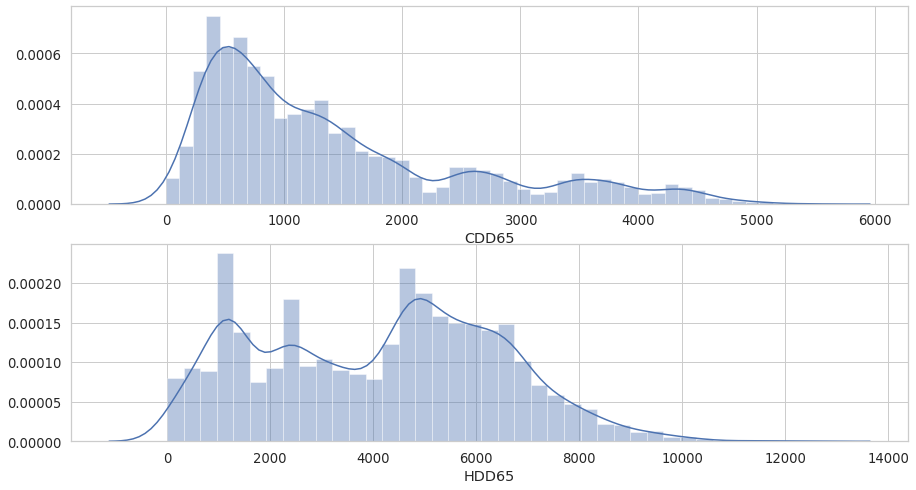

In [9]:
fig, axarr = plt.subplots(2,1,figsize=[15,8])
col = ['CDD65','HDD65']
for i in range(2):
    sns.distplot(df[col[i]],ax=axarr.flatten()[i],kde=True)
plt.savefig('DegreeDays.png',bbox_inches='tight')

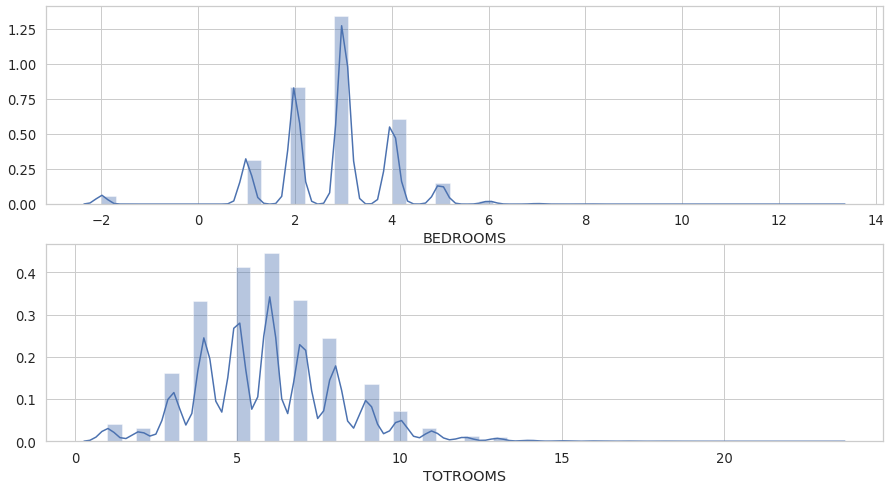

In [10]:
#WIP
fig, axarr = plt.subplots(2,1,figsize=[15,8])
col = ['BEDROOMS','TOTROOMS']
for i in range(2):
    sns.distplot(df[col[i]],ax=axarr.flatten()[i],kde=True)
plt.savefig('HouseRooms.png',bbox_inches='tight')

Split the data into training and evaluation

In [12]:
np.random.seed(seed=1) #makes result reproducible
msk = np.random.rand(len(df)) < 0.8
traindf = df[msk]
evaldf = df[~msk]

In [13]:
len(traindf)

9701

In [14]:
len(evaldf)

2382

## Training and Evaluation

We are trying to predict **KWH** target variable.


In [21]:
def add_more_features(df):
#     Improve a linear regression model with the addition of  synthetic features (WIP)
#     df['logCDD65'] = np.log(df['CDD65'])
#     df['logHDD65'] = np.log(df['HDD65'])
    return df

In [22]:
# Create pandas input function
def make_input_fn(df, num_epochs):
  return tf.compat.v1.estimator.inputs.pandas_input_fn(
    x = add_more_features(df),
    y = np.log(df['KWH']), # normalize with log function
    batch_size = 128,
    num_epochs = num_epochs,
    shuffle = True,
    queue_capacity = 1000,
    num_threads = 1
  )

In [23]:
# Define your feature columns
def create_feature_cols():
  return [
      tf.feature_column.numeric_column('CDD65'),
      tf.feature_column.numeric_column('HDD65'),
      #tf.feature_column.numeric_column('BEDROOMS'),
#       tf.feature_column.numeric_column('logCDD65'),
#       tf.feature_column.numeric_column('HDD65'),
#       tf.feature_column.categorical_column_with_vocabulary_list('IECC_Climate_Pub', vocabulary_list=['1A-2A','2B','3A','3B-4B','3C','4A','4C','5A','5B-5C','6A-6B','7A-7B-7AK-8AK']) #Type of housing unit
      #tf.feature_column.categorical_column_with_identity('TYPEHUQ', num_buckets=5), #Type of housing unit
      #tf.feature_column.weighted_categorical_column('TOTROOMS', 'NWEIGHT', dtype=tf.dtypes.float32)
      #tf.feature_column.categorical_column('TOTROOMS'),
      #tf.feature_column.embedding_column('CDD65',5,combiner='mean', initializer=None,    ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True),
      #tf.feature_column.embedding_column('HDD65',2,combiner='mean', initializer=None,    ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True)
  ]

In [24]:
# Create estimator train and evaluate function
def train_and_evaluate(output_dir, num_train_steps):
    estimator = tf.estimator.LinearRegressor(model_dir=output_dir,feature_columns=create_feature_cols())
    train_spec = tf.estimator.TrainSpec(input_fn = make_input_fn(traindf,8),max_steps=num_train_steps)
    eval_spec = tf.estimator.EvalSpec(input_fn = make_input_fn(evaldf,1),steps = None,start_delay_secs = 1,throttle_secs = 10)
    tf.estimator.train_and_evaluate(estimator,train_spec,eval_spec)

In [25]:
OUTDIR = './trained_model'

In [26]:
# Run the model
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time
tf.compat.v1.summary.FileWriterCache.clear() 
train_and_evaluate(OUTDIR, 2000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './trained_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fccdafd5050>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:te

#Export model for hosting

In [27]:
def json_serving_input_fn():
    """Build the serving inputs."""
    inputs = {}
    for feat in featurizer.INPUT_COLUMNS:
        inputs[feat.name] = tf.placeholder(shape=[None], dtype=feat.dtype)

    return tf.estimator.export.ServingInputReceiver(inputs, inputs)

In [28]:
def serving_input_receiver_fn():
    """Serving input_fn that builds features from placeholders

    Returns
    -------
    tf.estimator.export.ServingInputReceiver
    """
    number = tf.placeholder(dtype=tf.float32, shape=[None, 1], name='number')
    receiver_tensors = {'number': number}
    features = tf.tile(number, multiples=[1, 2])
    return tf.estimator.export.ServingInputReceiver(features, receiver_tensors)

In [29]:
!ls ./trained_model

checkpoint			   model.ckpt-0.index
eval				   model.ckpt-0.meta
events.out.tfevents.1598389824.K1  model.ckpt-607.data-00000-of-00001
graph.pbtxt			   model.ckpt-607.index
model.ckpt-0.data-00000-of-00001   model.ckpt-607.meta


In [ ]:
est_preds = estimator.predict(input_fn)
predictions = np.stack([x['values'] for x in est_preds], axis=0)
predictions.shape